In [1]:
import numpy as np
import pandas as pd
import rdkit
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from spectrum_func import *


import mordred
from mordred import Calculator, descriptors

In this notebook, I will be working with molecules that come from the first 6 years of work by Kevin Belfield. I'll start by presenting the Smiles strings for the moleulces that we care about. We can load these from a csv file


In [2]:
# read csv file called "Kevin_Belfield_Paper_Fluorene_Dataset.csv" and bring into pandas dataframe
# File seems to be in "ISO-8859-1" (also known as "latin1") encoding, so read the file as follows:
belfield = pd.read_csv("data/Kevin_Belfield_Paper_Fluorene_Dataset.csv", encoding='ISO-8859-1')
belfield.head(10)

,Year,smiles,CAS,DOI,LMA1 (nm),LMA2 (nm) assume hexane,2PAxs(cm4 s photon-1 molecule-1): Note the GöppertMayer (GM) stands for 10?50 cm4 s per photon molecule.,WhiteLightContinuum wavelength,identifier in paper,Comments,L-em (nm),Comment2,ExtCoeff,Unnamed: 13
0,1999,BrC=1C=CC=2C3=CC=C(C=C3C(C2C1)(CC)CC)N(C=4C=CC...,202831-64-9,10.1021/ol9909177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999,O=P(OCC)(OCC)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C...,252000-05-8,10.1021/ol9909177,308.0,383.0,6.500000e-48,605.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1999,O=N(=O)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C(C3C2)...,252000-06-9,10.1021/ol9909177,309.0,414.0,1.300000e-47,670.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,IC=1C=CC=2C3=CC=C(I)C=C3CC2C1,16218-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,7.0,intermediate,NaN,NaN,NaN,NaN
4,2000,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3...,262607-32-9,10.1021/jo991950+,NaN,392.0,8.200000e-48,615.0,4.0,NaN,475.0,NaN,NaN,NaN
5,2000,O=N(=O)C1=CC=C2C=3C=CC(I)=CC3CC2=C1,23055-47-2,10.1021/jo991950+,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6,2000,C=1C=CC(=CC1)N(C=2C=CC=CC2)C=3C=CC=4C5=CC=C(C=...,289892-10-0,10.1021/jo991950+,NaN,378.0,NaN,NaN,9.0,NaN,400.0,NaN,NaN,NaN
7,2000,IC=1C=CC=2C3=CC=C(I)C=C3C(C2C1)(CCCCCCCCCC)CCC...,249296-20-6,10.1021/jo991950+,NaN,NaN,NaN,NaN,8.0,intermediate,NaN,NaN,NaN,NaN
8,2000,O=N(=O)C1=CC=C2C=3C=CC(I)=CC3C(C2=C1)(CCCCCCCC...,262607-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,1.0,intermediate,NaN,NaN,NaN,NaN
9,2000,N1=C(SC=2C=CC=CC12)C3=CC=C4C5=CC=C(N)C=C5C(C4=...,262607-30-7,10.1021/jo991950+,NaN,380.0,NaN,NaN,3.0,Bathochromic shift of 15 nm expected for 3 rel...,NaN,NaN,NaN,NaN


In [3]:
# add a column called LEC to the dataframe
# LEC is the base-10 log of the ExtCoeff column
belfield['LEC'] = np.log10(belfield['ExtCoeff'])
belfield.head(10)

,Year,smiles,CAS,DOI,LMA1 (nm),LMA2 (nm) assume hexane,2PAxs(cm4 s photon-1 molecule-1): Note the GöppertMayer (GM) stands for 10?50 cm4 s per photon molecule.,WhiteLightContinuum wavelength,identifier in paper,Comments,L-em (nm),Comment2,ExtCoeff,Unnamed: 13,LEC
0,1999,BrC=1C=CC=2C3=CC=C(C=C3C(C2C1)(CC)CC)N(C=4C=CC...,202831-64-9,10.1021/ol9909177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999,O=P(OCC)(OCC)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C...,252000-05-8,10.1021/ol9909177,308.0,383.0,6.500000e-48,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999,O=N(=O)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C(C3C2)...,252000-06-9,10.1021/ol9909177,309.0,414.0,1.300000e-47,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,IC=1C=CC=2C3=CC=C(I)C=C3CC2C1,16218-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,7.0,intermediate,NaN,NaN,NaN,NaN,NaN
4,2000,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3...,262607-32-9,10.1021/jo991950+,NaN,392.0,8.200000e-48,615.0,4.0,NaN,475.0,NaN,NaN,NaN,NaN
5,2000,O=N(=O)C1=CC=C2C=3C=CC(I)=CC3CC2=C1,23055-47-2,10.1021/jo991950+,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2000,C=1C=CC(=CC1)N(C=2C=CC=CC2)C=3C=CC=4C5=CC=C(C=...,289892-10-0,10.1021/jo991950+,NaN,378.0,NaN,NaN,9.0,NaN,400.0,NaN,NaN,NaN,NaN
7,2000,IC=1C=CC=2C3=CC=C(I)C=C3C(C2C1)(CCCCCCCCCC)CCC...,249296-20-6,10.1021/jo991950+,NaN,NaN,NaN,NaN,8.0,intermediate,NaN,NaN,NaN,NaN,NaN
8,2000,O=N(=O)C1=CC=C2C=3C=CC(I)=CC3C(C2=C1)(CCCCCCCC...,262607-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,1.0,intermediate,NaN,NaN,NaN,NaN,NaN
9,2000,N1=C(SC=2C=CC=CC12)C3=CC=C4C5=CC=C(N)C=C5C(C4=...,262607-30-7,10.1021/jo991950+,NaN,380.0,NaN,NaN,3.0,Bathochromic shift of 15 nm expected for 3 rel...,NaN,NaN,NaN,NaN,NaN


In [4]:
# mask all the rows and filter out any with NaN as a smiles string
mask = belfield['smiles'].notnull()
belfield = belfield[mask]
belfield.head()

,Year,smiles,CAS,DOI,LMA1 (nm),LMA2 (nm) assume hexane,2PAxs(cm4 s photon-1 molecule-1): Note the GöppertMayer (GM) stands for 10?50 cm4 s per photon molecule.,WhiteLightContinuum wavelength,identifier in paper,Comments,L-em (nm),Comment2,ExtCoeff,Unnamed: 13,LEC
0,1999,BrC=1C=CC=2C3=CC=C(C=C3C(C2C1)(CC)CC)N(C=4C=CC...,202831-64-9,10.1021/ol9909177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999,O=P(OCC)(OCC)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C...,252000-05-8,10.1021/ol9909177,308.0,383.0,6.500000e-48,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999,O=N(=O)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C(C3C2)...,252000-06-9,10.1021/ol9909177,309.0,414.0,1.300000e-47,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,IC=1C=CC=2C3=CC=C(I)C=C3CC2C1,16218-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,7.0,intermediate,NaN,NaN,NaN,NaN,NaN
4,2000,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3...,262607-32-9,10.1021/jo991950+,NaN,392.0,8.200000e-48,615.0,4.0,NaN,475.0,NaN,NaN,NaN,NaN


In [5]:
# add an rdkit 'mol' column to dataframe and populate it with the rdkit mol object for each smiles string
belfield['mol'] = belfield['smiles'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
belfield.head()

,Year,smiles,CAS,DOI,LMA1 (nm),LMA2 (nm) assume hexane,2PAxs(cm4 s photon-1 molecule-1): Note the GöppertMayer (GM) stands for 10?50 cm4 s per photon molecule.,WhiteLightContinuum wavelength,identifier in paper,Comments,L-em (nm),Comment2,ExtCoeff,Unnamed: 13,LEC,mol
0,1999,BrC=1C=CC=2C3=CC=C(C=C3C(C2C1)(CC)CC)N(C=4C=CC...,202831-64-9,10.1021/ol9909177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x153a45ba0>
1,1999,O=P(OCC)(OCC)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C...,252000-05-8,10.1021/ol9909177,308.0,383.0,6.500000e-48,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x153a45c10>
2,1999,O=N(=O)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C(C3C2)...,252000-06-9,10.1021/ol9909177,309.0,414.0,1.300000e-47,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x153a459e0>
3,2000,IC=1C=CC=2C3=CC=C(I)C=C3CC2C1,16218-28-3,10.1021/jo991950+,NaN,NaN,NaN,NaN,7.0,intermediate,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x153a45c80>
4,2000,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3...,262607-32-9,10.1021/jo991950+,NaN,392.0,8.200000e-48,615.0,4.0,NaN,475.0,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x153a45ac0>


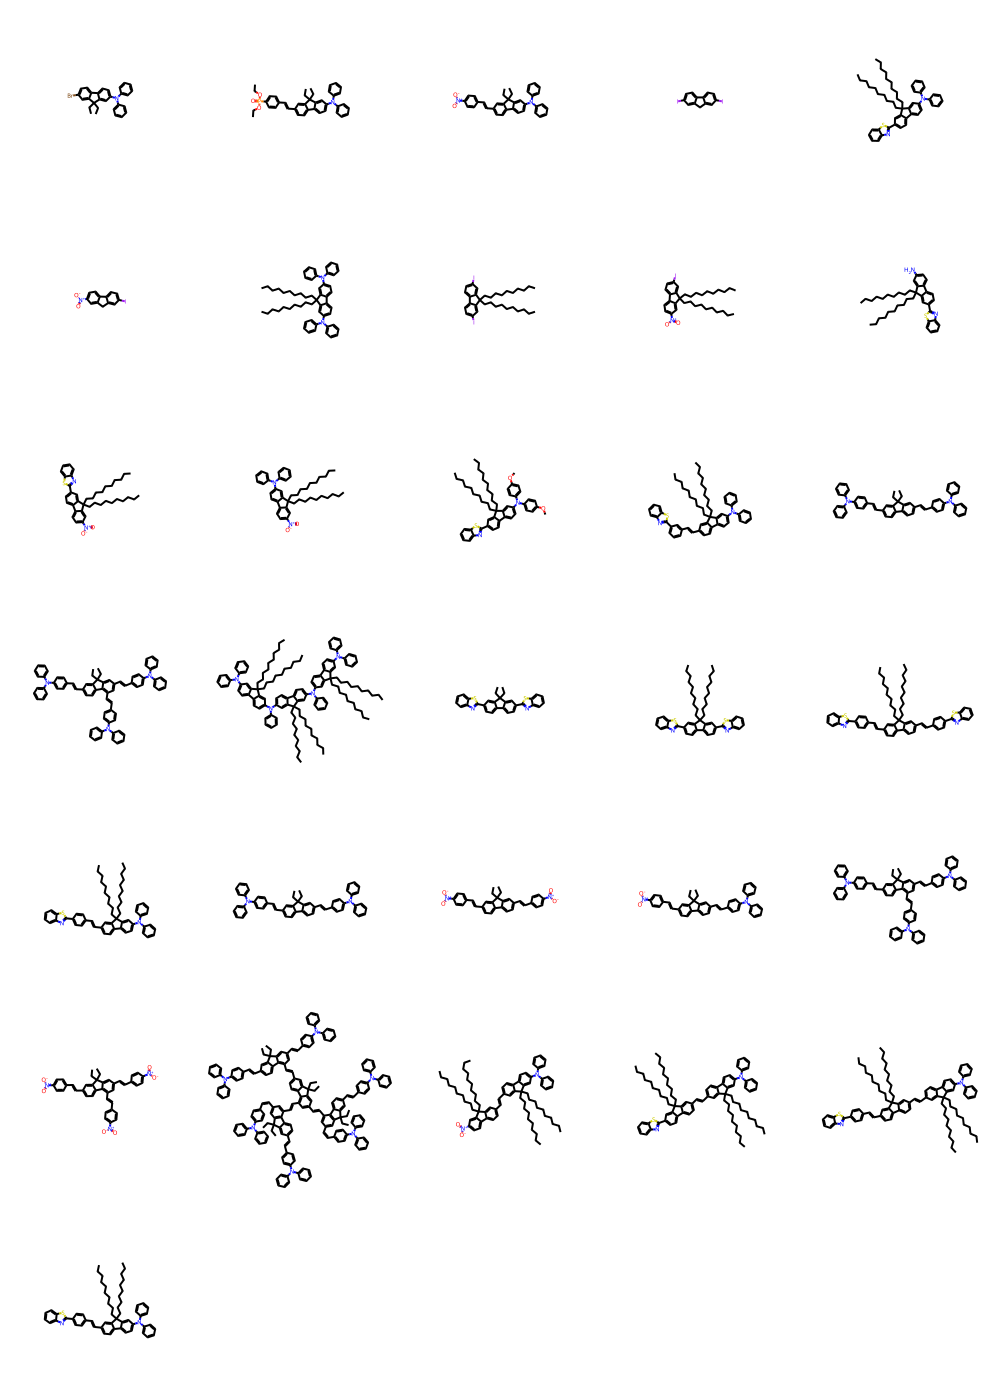

In [6]:
# draw the mol object for all the rows into a grid
rdkit.Chem.Draw.MolsToGridImage(belfield['mol'], molsPerRow=5, subImgSize=(200, 200))

N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3)(CCCCCCCCCC)CCCCCCCCCC)N(C=6C=CC=CC6)C=7C=CC=CC7


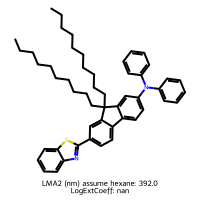

In [7]:
# draw the mol from the 5th row in belfield dataframe
print (belfield['smiles'][4])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][4]) + "\n" + "LogExtCoeff: " + str(belfield['LEC'][4])
rdkit.Chem.Draw.MolToImage(belfield['mol'][4], size=(200, 200), legend=legend)

This molecule was a very interesting first molecule for Belfield. It has a donor group and an acceptor group on the molecule. There are also some long alkyl chains that aid in the solubility of the molecule, which we will keep because Belfield's group quickly realized that these particular side groups did relatively little to the performance.<br>
The key now is to try our model to predict the Lambda-max (wavelength at which absorbance is maximum, 392 nm in this case) and the LogExtinctionCoefficient, unknown. 

C=1C=CC(=CC1)N(C=2C=CC=CC2)C=3C=CC=4C5=CC=C(C=C5C(C4C3)(CCCCCCCCCC)CCCCCCCCCC)N(C=6C=CC=CC6)C=7C=CC=CC7


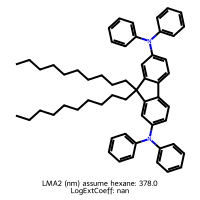

In [8]:
print (belfield['smiles'][6])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][6]) + "\n" + "LogExtCoeff: " + str(belfield['LEC'][6])
rdkit.Chem.Draw.MolToImage(belfield['mol'][6], size=(200, 200), legend=legend)

In [9]:
len(belfield)

31

N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=CC6=CC=C7C8=CC=C(C=C8C(C7=C6)(CCCCCCCCCC)CCCCCCCCCC)N(C=9C=CC=CC9)C=%10C=CC=CC%10)C=C5C(C4=C3)(CCCCCCCCCC)CCCCCCCCCC


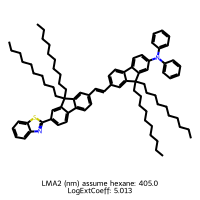

In [10]:
print (belfield['smiles'][30])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][30]) + "\n" + f"LogExtCoeff: {belfield['LEC'][30]:.3f}"
rdkit.Chem.Draw.MolToImage(belfield['mol'][30], size=(200, 200), legend=legend)

N1=C(SC2=CC=CC=C12)C3=CC=C(C=CC4=CC=C5C6=CC=C(C=CC7=CC=C8C9=CC=C(C=C9C(C8=C7)(CCCCCCCCCC)CCCCCCCCCC)N(C=%10C=CC=CC%10)C=%11C=CC=CC%11)C=C6C(C5=C4)(CCCCCCCCCC)CCCCCCCCCC)C=C3


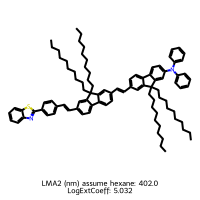

In [11]:
# draw the mol from the 5th row in belfield dataframe
# label the image with the corresponding belfield['LMA2 (nm) assume hexane'] and belfield['ExtCoeff'] values taken from belfield as text on the image
print (belfield['smiles'][31])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][31]) + "\n" + f"LogExtCoeff: {belfield['LEC'][31]:.3f}"
rdkit.Chem.Draw.MolToImage(belfield['mol'][31], size=(200, 200), legend=legend)


O=N(=O)C1=CC=C2C3=CC=C(C=CC4=CC=C5C6=CC=C(C=C6C(C5=C4)(CCCCCCCCCC)CCCCCCCCCC)N(C=7C=CC=CC7)C=8C=CC=CC8)C=C3C(C2=C1)(CCCCCCCCCC)CCCCCCCCCC


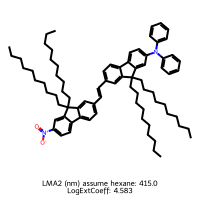

In [12]:
# draw the mol from the 5th row in belfield dataframe
# label the image with the corresponding belfield['LMA2 (nm) assume hexane'] and belfield['ExtCoeff'] values taken from belfield as text on the image
print (belfield['smiles'][29])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][29]) + "\n" + f"LogExtCoeff: {belfield['LEC'][29]:.3f}"
rdkit.Chem.Draw.MolToImage(belfield['mol'][29], size=(200, 200), legend=legend)


N1=C(SC2=CC=CC=C12)C3=CC=C(C=CC4=CC=C5C6=CC=C(C=C6C(C5=C4)(CCCCCCCCCC)CCCCCCCCCC)N(C=7C=CC=CC7)C=8C=CC=CC8)C=C3


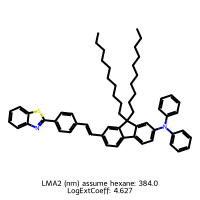

In [13]:
# draw the mol from the 5th row in belfield dataframe
# label the image with the corresponding belfield['LMA2 (nm) assume hexane'] and belfield['ExtCoeff'] values taken from belfield as text on the image
print (belfield['smiles'][32])
legend = "LMA2 (nm) assume hexane: " + str(belfield['LMA2 (nm) assume hexane'][32]) + "\n" + f"LogExtCoeff: {belfield['LEC'][32]:.3f}"
rdkit.Chem.Draw.MolToImage(belfield['mol'][32], size=(200, 200), legend=legend)


In [14]:
def smarts_from_substructure_smiles(substructure_smiles):
    substructure_mol = rdkit.Chem.MolFromSmiles(substructure_smiles)
    substructure_smarts = rdkit.Chem.MolToSmarts(substructure_mol)
    print (f"substructure_smarts is {substructure_smarts}")
    substructure_mol = rdkit.Chem.MolFromSmarts(substructure_smarts)
    return substructure_mol, substructure_smarts

substructure_smarts is [#6]1(-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6])(-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6])-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-1


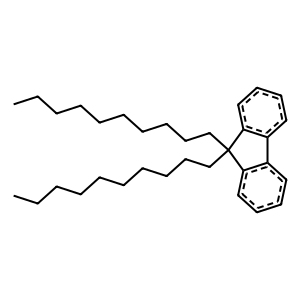

In [15]:
# Input the smiles string of interest:
sol_fluorene_smiles = 'C1(CCCCCCCCCC)(CCCCCCCCCC)C2=CC=CC=C2C3=CC=CC=C31'
sol_fluorene_mol, sol_fluorene_smarts = smarts_from_substructure_smiles(sol_fluorene_smiles)
# Then plot the substructure to check it is correct (visually)
rdkit.Chem.Draw.MolToImage(sol_fluorene_mol)


Create datasets of fluorenes with i) LMA and ii) LEC values

In [16]:
# create datafram of smiles, and LMA, using the belfield[smiles] and belfield['LMA2 (nm) assume hexane'] columns
# filter out all rows where there is either no smiles string or no LMA value
belfield_LMA = belfield[['smiles', 'LMA2 (nm) assume hexane']]
belfield_LMA = belfield_LMA[belfield_LMA['smiles'].notnull()]
belfield_LMA = belfield_LMA[belfield_LMA['LMA2 (nm) assume hexane'].notnull()]
print (f"The length of the df is {len(belfield_LMA)} after masking")
belfield_LMA.head()


The length of the df is 22 after masking


,smiles,LMA2 (nm) assume hexane
1,O=P(OCC)(OCC)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C...,383.0
2,O=N(=O)C1=CC=C(C=CC=2C=CC=3C4=CC=C(C=C4C(C3C2)...,414.0
4,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=C5C(C4=C3...,392.0
6,C=1C=CC(=CC1)N(C=2C=CC=CC2)C=3C=CC=4C5=CC=C(C=...,378.0
9,N1=C(SC=2C=CC=CC12)C3=CC=C4C5=CC=C(N)C=C5C(C4=...,380.0


In [18]:
# create datafram of smiles, and LMA, using the belfield[smiles] and belfield['LMA2 (nm) assume hexane'] columns
# filter out all rows where there is either no smiles string or no LMA value
belfield_LEC = belfield[['smiles', 'LEC']]
belfield_LEC = belfield_LEC[belfield_LEC['smiles'].notnull()]
belfield_LEC = belfield_LEC[belfield_LEC['LEC'].notnull()]
print (f"The length of the df is {len(belfield_LEC)} after masking")
belfield_LEC.head()


The length of the df is 7 after masking


,smiles,LEC
23,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC=4C=CC=...,5.000000
26,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC=4C=CC5...,5.000000
28,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC4=CC=C5...,5.477121
29,O=N(=O)C1=CC=C2C3=CC=C(C=CC4=CC=C5C6=CC=C(C=C6...,4.582745
30,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=CC6=CC=C7...,5.012837


In [19]:
# save belfield_LEC and belfield_LMA to parquet format for retrieval later
belfield_LEC.to_parquet("data/belfield_LEC.parquet")
belfield_LMA.to_parquet("data/belfield_LMA.parquet")
# save belfield_LEC and belfield_LMA to csv format for retrieval later
belfield_LEC.to_csv("data/belfield_LEC.csv")
belfield_LMA.to_csv("data/belfield_LMA.csv")